### Slope y Aspect

Dentro de las propuestas de variables que fueron detalladas en el fichero anterior, dos de ellas incluían la integración de variables topografícas adicionales: slope y aspect. Sin embargo, a diferencia de la primera propuesta, tanto el slope como el aspect necesitan ser calculadas a partir de, en este caso, ```Terrain Height``` (normalmente se utilizan archivos DEM para ello). Por lo mismo, en este fichero se expondrá el proceso de obtención de estas nuevas variables.

#### 1.1 Importación de información HGT

Veamos un ejemplo para el mapa completo que luego será replicado para cada uno de los parches creados en el fichero anterior. Importemos un archivo d03 original y extraigamos la variable HGT:

In [37]:
import richdem as rd
import xarray as xr
import numpy as np
import warnings

warnings.filterwarnings("ignore")


path   = "extra/files/wrfout_d03_2015-10-25_12%3A00%3A00" #ruta de ejemplo de salida
output = xr.open_dataset(path)
hgt    = output.HGT
hgt

<xarray.DataArray 'HGT' (Time: 1, south_north: 171, west_east: 81)> Size: 55kB
[13851 values with dtype=float32]
Coordinates:
    XLAT     (Time, south_north, west_east) float32 55kB ...
    XLONG    (Time, south_north, west_east) float32 55kB ...
    XTIME    (Time) datetime64[ns] 8B ...
Dimensions without coordinates: Time, south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  Terrain Height
    units:        m
    stagger:

Para efectos del cálculo del slope y aspect, se necesita darle el formato ```richdem.darray``` para así ocupar los métodos ```TerrainAttribute``` de la misma librería [richdem](https://richdem.readthedocs.io/en/latest/):

>> "Se calcula la pendiente de una celda focal utilizando una estimación de diferencia central de una superficie ajustada a la celda focal y sus vecinos. La pendiente  (slope) elegida es la máxima de esta superficie"

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


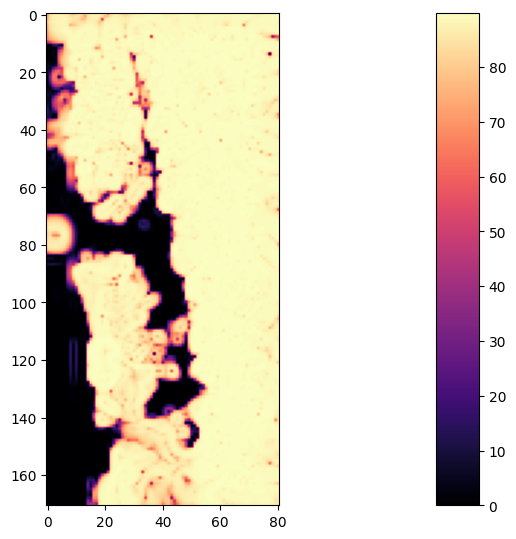

In [38]:
import matplotlib.pyplot as plt

hgt_rd = rd.rdarray(hgt[0], no_data=np.nan) 
slope = rd.TerrainAttribute(hgt_rd, attrib='slope_degrees') #slope_riserun, slope_percentage, slope_degrees, slope_radians
rd.rdShow(slope, axes=True, cmap='magma', figsize=(8, 5.5))
plt.show()

Para efectos del aspect, el proceso es análogo:

>> "Calcula el aspect como la dirección de la pendiente máxima de la celda focal. El valor devuelto está en grados"

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


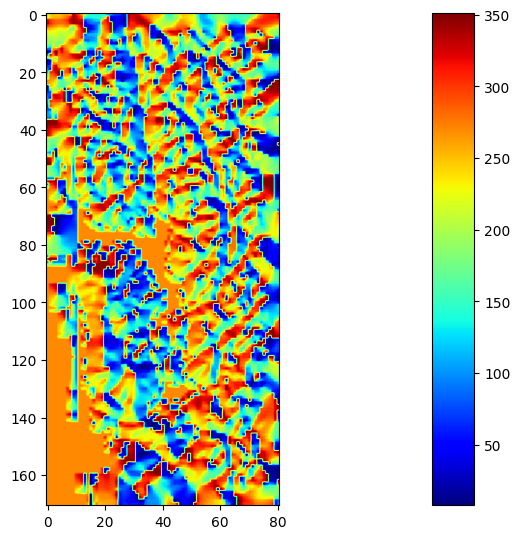

In [39]:
aspect = rd.TerrainAttribute(hgt_rd, attrib='aspect')
rd.rdShow(aspect, axes=True, cmap='jet', figsize=(8, 5.5))
plt.show()

#### 1.2 Cálculo para los parches

Ahora que ya se tiene una comprensión de cómo se calculan estas nuevas variables a partir de la ya existente ```Terrain Height```, procedemos a calcularlas para todo el conjunto de entrenamiento ya dividido en parches. 

Nota: Calcularemos el Aspect y Slope sobre el dominio acotado con parches ya interpolados, quizás sea interesante calcular estas variables a partir de los archivos d03 y d05 originales.

In [ ]:
from tqdm import tqdm 

ruta= "../../parches_winscp/bicubic_32_32/190824_16_tr/raw/hgt_input_raw_190824_16_tr.npy"
hgt_npy = np.load(ruta)[:,:,:,0] 
hgt_rd = rd.rdarray(hgt_npy, no_data=np.nan) 

stack_1=[]; stack_2=[]
for i in tqdm(range(hgt_npy.shape[0])):
    slope_i  = rd.TerrainAttribute(hgt_rd[i], attrib='slope_degrees')
    aspect_i = rd.TerrainAttribute(hgt_rd[i], attrib='aspect')

    stack_1.append(slope_i)
    stack_2.append(aspect_i)

slope_var  = np.expand_dims(np.stack(stack_1, axis=0), axis=-1)
aspect_var = np.expand_dims(np.stack(stack_2, axis=0), axis=-1)

np.save("../../parches_winscp/bicubic_32_32/190824_16_tr/raw/slope_input_raw_190824_16_tr.npy", slope_var)
np.save("../../parches_winscp/bicubic_32_32/190824_16_tr/raw/aspect_input_raw_190824_16_tr.npy", aspect_var)

In [ ]:
ruta= "../../parches_winscp/bicubic_32_32/190824_16_va/raw/hgt_input_raw_190824_16_va.npy"
hgt_npy = np.load(ruta)[:,:,:,0] 
hgt_rd = rd.rdarray(hgt_npy, no_data=np.nan) 

stack_1=[]; stack_2=[]
for i in tqdm(range(hgt_npy.shape[0])):
    slope_i  = rd.TerrainAttribute(hgt_rd[i], attrib='slope_degrees')
    aspect_i = rd.TerrainAttribute(hgt_rd[i], attrib='aspect')

    stack_1.append(slope_i)
    stack_2.append(aspect_i)

slope_var  = np.expand_dims(np.stack(stack_1, axis=0), axis=-1)
aspect_var = np.expand_dims(np.stack(stack_2, axis=0), axis=-1)

np.save("../../parches_winscp/bicubic_32_32/190824_16_va/raw/slope_input_raw_190824_16_va.npy", slope_var)
np.save("../../parches_winscp/bicubic_32_32/190824_16_va/raw/aspect_input_raw_190824_16_va.npy", aspect_var)

#### 1.3 Aún más variables: Sheltering y Exposure

Estas nuevas variables forman parte de la tercera propuesta y tienen como fin entregar información de la interacción del viento con la topografía. Según [(WindTopo, 2022)](https://rmets.onlinelibrary.wiley.com/doi/full/10.1002/qj.4265), estas variables se calculan dada la siguiente fórmula:

$$ E_{+} = \max \left( \sin ( \alpha), 0 \right) \\
E_{-} = \min \left( \sin ( \alpha), 0 \right)  \\ 
where $$
$$ \alpha = \arctan ( \tan ( slope ) \cos ( \delta) ) \\
\delta = \arctan2 ( - v_c , u_c) - aspect $$

Utilicemos el archivo importado al comienzo del fichero como ejemplo para calcular estas nuevas variables:

In [47]:
hgt_rd = rd.rdarray(hgt[0], no_data=np.nan) 

slope = rd.TerrainAttribute(hgt_rd, attrib='slope_degrees')
aspect = rd.TerrainAttribute(hgt_rd, attrib='aspect')
u10   = output.U10 
v10   = output.V10 


delta = np.arctan2(-v10, -u10) - aspect 
alpha = np.arctan(  np.tan(np.radians(slope) * np.cos(delta) ) )

E_max = np.maximum( np.sin(alpha), 0) 
E_min = np.minimum( np.sin(alpha), 0)


Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


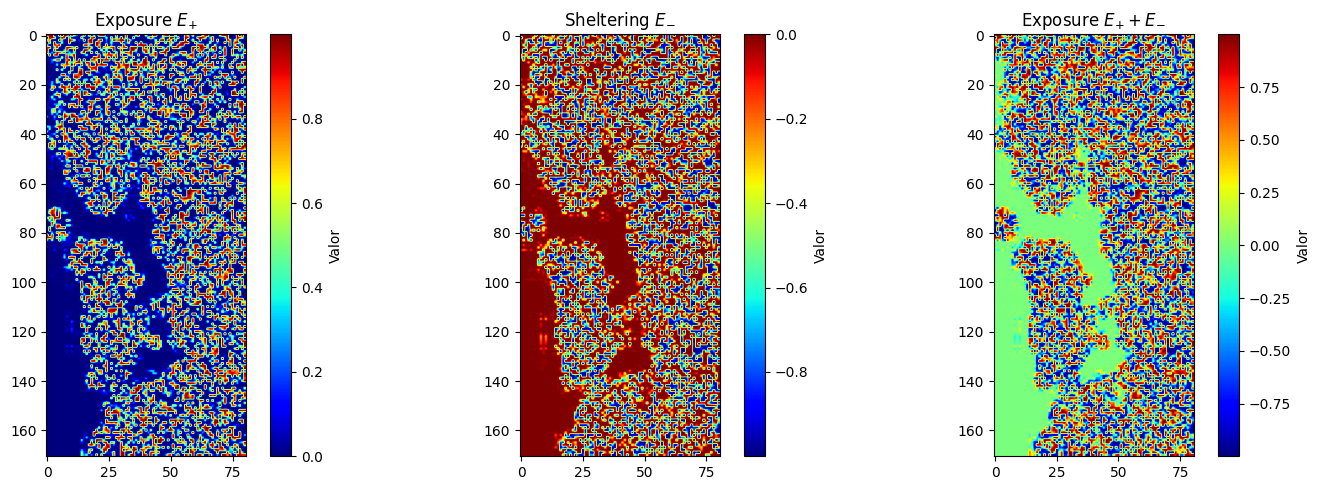

In [56]:
plt.figure(figsize=(15, 5))  


plt.subplot(1, 3, 1)  
plt.imshow(E_max[0], cmap='jet', interpolation=None)
plt.title("Exposure $E_{+}$", fontsize=12)
plt.colorbar(label='Valor')

plt.subplot(1, 3, 2)  
plt.imshow(E_min[0], cmap='jet', interpolation=None)
plt.title("Sheltering $E_{-}$", fontsize=12)
plt.colorbar(label='Valor')

plt.subplot(1, 3, 3)  
plt.imshow(E_max[0] + E_min[0], cmap='jet', interpolation=None)
plt.title("Exposure $E_{+} + E_{-}$", fontsize=12)
plt.colorbar(label='Valor')

plt.tight_layout()
plt.show()


Nuestro amigo de WindTopo nos dice lo siguiente: "Como una red neuronal convolucional (CNN) no puede multiplicar directamente algunos de sus inputs, y dado que nuestro modelo mostró dificultades para aprenderlo, proporcionamos $E_{+ u_c}, E_{+ v_c}, E_{- u_c}$ y $E_{- v_c}$. Nos uniremos a esta idea y procederemos a calcular estas nuevas combinaciones de variables que se convertirán en las nuevas entradas de nuestro modelo.

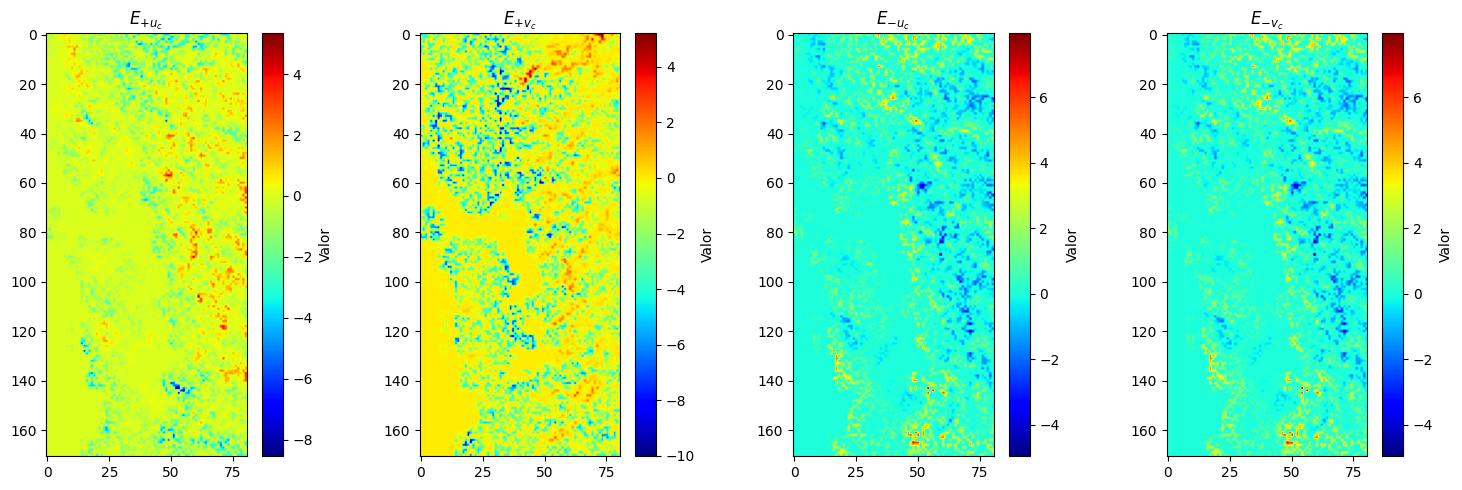

In [59]:
plt.figure(figsize=(15, 5)) 

plt.subplot(1, 4, 1)  
plt.imshow(E_max[0] * u10[0], cmap='jet', interpolation=None)
plt.title("$E_{+ u_c}$", fontsize=12)
plt.colorbar(label='Valor')

plt.subplot(1, 4, 2)  
plt.imshow(E_max[0] * v10, cmap='jet', interpolation=None)
plt.title("$E_{+ v_c}$", fontsize=12)
plt.colorbar(label='Valor')

plt.subplot(1, 4, 3) 
plt.imshow(E_min[0] * u10, cmap='jet', interpolation=None)
plt.title("$E_{- u_c}$", fontsize=12)
plt.colorbar(label='Valor')

plt.subplot(1, 4, 4) 
plt.imshow(E_min[0] * u10, cmap='jet', interpolation=None)
plt.title("$E_{- v_c}$", fontsize=12)
plt.colorbar(label='Valor')

plt.tight_layout()
plt.show()

#### 1.4 Cálculos de las variables $E_{+}$ y $E_{-}$ y sus combinaciones

In [68]:
u10_tr    = np.load("../../parches_winscp/bicubic_32_32/190824_16_tr/raw/u10_input_raw_190824_16_tr.npy")
v10_tr    = np.load("../../parches_winscp/bicubic_32_32/190824_16_tr/raw/v10_input_raw_190824_16_tr.npy")
slope_tr  = np.load("../../parches_winscp/bicubic_32_32/190824_16_tr/raw/slope_input_raw_190824_16_tr.npy")
aspect_tr = np.load("../../parches_winscp/bicubic_32_32/190824_16_tr/raw/aspect_input_raw_190824_16_tr.npy")

delta = np.arctan2(- v10_tr, - u10_tr) - aspect_tr
alpha = np.arctan(  np.tan(np.radians(slope_tr) * np.cos(delta) ) )

E_max_tr = np.maximum( np.sin(alpha), 0) 
E_min_tr = np.minimum( np.sin(alpha), 0)

np.save("../../parches_winscp/bicubic_32_32/190824_16_tr/raw/Emax_input_raw_190824_16_tr.npy", E_max_tr)
np.save("../../parches_winscp/bicubic_32_32/190824_16_tr/raw/Emin_input_raw_190824_16_tr.npy", E_min_tr)

In [70]:
np.save("../../parches_winscp/bicubic_32_32/190824_16_tr/raw/EmaxU_input_raw_190824_16_tr.npy", E_max_tr * u10_tr)
np.save("../../parches_winscp/bicubic_32_32/190824_16_tr/raw/EminU_input_raw_190824_16_tr.npy", E_min_tr * u10_tr)

np.save("../../parches_winscp/bicubic_32_32/190824_16_tr/raw/EmaxV_input_raw_190824_16_tr.npy", E_max_tr * v10_tr)
np.save("../../parches_winscp/bicubic_32_32/190824_16_tr/raw/EminV_input_raw_190824_16_tr.npy", E_min_tr * v10_tr)

In [69]:
u10_va   = np.load("../../parches_winscp/bicubic_32_32/190824_16_va/raw/u10_input_raw_190824_16_va.npy")
v10_va    = np.load("../../parches_winscp/bicubic_32_32/190824_16_va/raw/v10_input_raw_190824_16_va.npy")
slope_va  = np.load("../../parches_winscp/bicubic_32_32/190824_16_va/raw/slope_input_raw_190824_16_va.npy")
aspect_va = np.load("../../parches_winscp/bicubic_32_32/190824_16_va/raw/aspect_input_raw_190824_16_va.npy")

delta = np.arctan2(- v10_va, - u10_va) - aspect_va
alpha = np.arctan(  np.tan(np.radians(slope_va) * np.cos(delta) ) )

E_max_va = np.maximum( np.sin(alpha), 0) 
E_min_va = np.minimum( np.sin(alpha), 0)

np.save("../../parches_winscp/bicubic_32_32/190824_16_va/raw/Emax_input_raw_190824_16_va.npy", E_max_va)
np.save("../../parches_winscp/bicubic_32_32/190824_16_va/raw/Emin_input_raw_190824_16_va.npy", E_min_va)

In [71]:
np.save("../../parches_winscp/bicubic_32_32/190824_16_va/raw/EmaxU_input_raw_190824_16_va.npy", E_max_va * u10_va)
np.save("../../parches_winscp/bicubic_32_32/190824_16_va/raw/EminU_input_raw_190824_16_va.npy", E_min_va * u10_va)

np.save("../../parches_winscp/bicubic_32_32/190824_16_va/raw/EmaxV_input_raw_190824_16_va.npy", E_max_va * v10_va)
np.save("../../parches_winscp/bicubic_32_32/190824_16_va/raw/EminV_input_raw_190824_16_va.npy", E_min_va * v10_va)

Finalmente resta calcular estas mismas variables para los demás dataset.